<a href="https://colab.research.google.com/github/ihsienlee/GitMdFile/blob/master/examples/PDEs/Part_2_PINN_BurgersEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Networks (PINNs) in Neuromancer

This tutorial demonstrates the use of [PINNs](https://en.wikipedia.org/wiki/Physics-informed_neural_networks) for solving partial differential equations (PDEs) in the Neuromancer library.

<img src="https://github.com/pnnl/neuromancer/blob/master/examples/figs/PINNs.png?raw=1" width="600">  

### References

[1] [Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations.](https://www.sciencedirect.com/science/article/abs/pii/S0021999118307125)

[2] https://github.com/jdtoscano94/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets/tree/main

[3] https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main


## Install (Colab only)
Skip this step when running locally.

In [1]:
!pip install neuromancer
!pip install pyDOE

*Note: When running on Colab, one might encounter a pip dependency error with Lida 0.0.10. This can be ignored*

## Imports

In [2]:
# torch and numpy imports
import torch
import torch.nn as nn
import numpy as np

# data imports
from scipy.io import loadmat

# plotting imports
import matplotlib.pyplot as plt

# filter some user warnings from torch broadcast
import warnings
warnings.filterwarnings("ignore")


In [3]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


## Problem Setup

**[Burgers' Equation](https://en.wikipedia.org/wiki/Burgers%27_equation)** is convection–diffusion equation occurring in various areas of applied mathematics, such as fluid mechanics, nonlinear acoustics, gas dynamics, and traffic flow. The equation is given as:

$$\frac{\partial y}{\partial t}+ y\frac{\partial y}{\partial x}=\nu\frac{\partial^2 y}{\partial x^2} $$

$$x\in[-1,1]$$
$$t\in[0,1]$$

Where $(x, t)$ represent spatio-temporal coordinates, $y(x, t)$ is the speed of the fluid at these corrdinates, and $\nu = 0.01/\pi$ represents the diffusion coefficient (or kinematic viscosity in the fluid mechanical context).

**Initial Condition:**

$$y(x,0)= -sin(\pi x)$$

**Boundary Conditions:**

$$y(−1, t) = 0$$
$$y(1, t) = 0$$




### Generate data of the exact solution

In [6]:
# Download the data if running on Colab
local_path = "/content/data/burgers_shock.mat"
url = "https://github.com/pnnl/neuromancer/raw/master/examples/PDEs/data/burgers_shock.mat"
!mkdir -p /content/data
!wget -O {local_path} {url}

# data = loadmat('./data/burgers_shock.mat')
data = loadmat(local_path)
x = data['x']                                   # space:      256 points between -1 and 1 [256x1]
t = data['t']                                   # time:       100 time points between 0 and 1 [100x1]
ysol = data['usol']                             # velocitu:   PDE solution [256x100]

nu = 0.01/np.pi                                 #diffusion coeficient

X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
X = torch.tensor(X.T).float()
T = torch.tensor(T.T).float()
y_real = torch.tensor(ysol).float()

--2025-06-08 08:01:43--  https://github.com/pnnl/neuromancer/raw/master/examples/PDEs/data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pnnl/neuromancer/master/examples/PDEs/data/burgers_shock.mat [following]
--2025-06-08 08:01:44--  https://raw.githubusercontent.com/pnnl/neuromancer/master/examples/PDEs/data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘/content/data/burgers_shock.mat’

/content/data/burge 100%[===================>] 203.07K  --.-KB/s    in 0.02s   

2025-06-08 08:01:44 (9.80 MB/s) - ‘/

In [7]:
print(X.shape, T.shape, y_real.shape)

torch.Size([256, 100]) torch.Size([256, 100]) torch.Size([256, 100])


### Plot the solution

In [8]:
def plot3D(X, T, y):
    X = X.detach().numpy()
    T = T.detach().numpy()
    y = y.detach().numpy()

    #     2D
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    cm = ax1.contourf(T, X, y, 20,cmap="viridis")
    fig.colorbar(cm, ax=ax1) # Add a colorbar to a plot
    ax1.set_title('u(x,t)')
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_aspect('equal')
        #     3D
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(T, X, y,cmap="viridis")
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.set_zlabel('u(x,t)')
    fig.tight_layout()

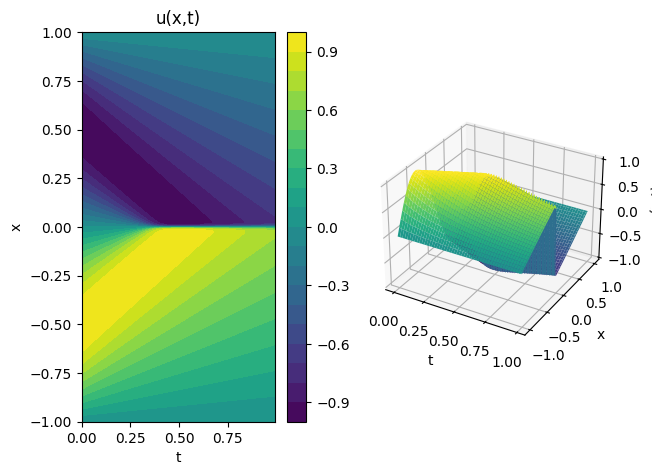

In [9]:
plot3D(X, T, y_real)

### Test data: PDE solution

In [10]:
X_test = X.reshape(-1,1)
T_test = T.reshape(-1,1)
Y_test = y_real.reshape(-1,1)

##  Construct training datasets

We construct training and development datasets containing [collocation points (CP)](https://en.wikipedia.org/wiki/Collocation_method) of the spatio-temporal domain (x,t), and samples of the [initial conditions (IC)](https://en.wikipedia.org/wiki/Initial_condition), and [boundary conditions (BC)](https://en.wikipedia.org/wiki/Boundary_value_problem).

The dataset is given as:
$\Xi_{\text{train/dev}} = [\texttt{CP}^i, \texttt{IC}^j, \texttt{BC}^j]$, $i = 1,...,N_f$, $j = 1,...,N_u$  
Where $N_f$ defines number of collocation points, and $N_u$ number of initial and boundary condition samples.

### Samples of Initial Condition (IC)

In [11]:
#   Left Edge: u(x,0) = -sin(pi*x)
left_X = X[:, [0]]
left_T = T[:, [0]]
left_Y = -torch.sin(np.pi * left_X[:, 0]).unsqueeze(1)
print(left_X.shape, left_T.shape, left_Y.shape)

torch.Size([256, 1]) torch.Size([256, 1]) torch.Size([256, 1])


### Samples of Boundary Conditions (BC)

In [12]:
#   Bottom Edge: x=min; tmin=<t=<max
bottom_X = X[[0], :].T
bottom_T = T[[0], :].T
bottom_Y = torch.zeros(bottom_X.shape[0], 1)
print(bottom_X.shape, bottom_T.shape, bottom_Y.shape)
#   Top Edge: x=max; 0=<t=<1
top_X = X[[-1], :].T
top_T = T[[-1], :].T
top_Y = torch.zeros(top_X.shape[0], 1)
print(top_X.shape, top_T.shape, top_Y.shape)

torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1])


### Number of training samples for IC and BC

In [13]:
# Get all the initial and boundary condition data
X_train = torch.vstack([left_X, bottom_X, top_X])
T_train = torch.vstack([left_T, bottom_T, top_T])
Y_train = torch.vstack([left_Y, bottom_Y, top_Y])
print(X_train.shape, T_train.shape, Y_train.shape)

# Choose (Nu) Number of training points for initial and boundary conditions
Nu = 200

# Randomly sample Nu points of our available initial and boundary condition data:
idx = np.sort(np.random.choice(X_train.shape[0], Nu, replace=False))
X_train_Nu = X_train[idx, :].float()  # Training Points  of x at (IC+BC)
T_train_Nu = T_train[idx, :].float()  # Training Points  of t at (IC+BC)
Y_train_Nu = Y_train[idx, :].float()  # Training Points  of y at (IC+BC)
print(X_train_Nu.shape, T_train_Nu.shape, Y_train_Nu.shape)

torch.Size([456, 1]) torch.Size([456, 1]) torch.Size([456, 1])
torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 1])


### Samples of Collocation Points (CP)

In [14]:
# x Domain bounds
x_lb = X_test[0]    # [-1.]
x_ub = X_test[-1]   # [1.]
print(x_lb, x_ub)

# t Domain bounds
t_lb = T_test[0]    # [0.]
t_ub = T_test[-1]   # [0.99]
print(t_lb, t_ub)

#  Choose (Nf) Collocation Points to Evaluate the PDE on
Nf = 1000  # Nf: Number of collocation points (Evaluate PDE)

# generate collocation points (CP)
X_train_CP = torch.FloatTensor(Nf, 1).uniform_(float(x_lb), float(x_ub))
T_train_CP = torch.FloatTensor(Nf, 1).uniform_(float(t_lb), float(t_ub))
print(X_train_CP.shape, T_train_CP.shape)

# add IC+BC to the collocation points
X_train_Nf = torch.vstack((X_train_CP, X_train_Nu)).float()  # Collocation Points of x (CP)
T_train_Nf = torch.vstack((T_train_CP, T_train_Nu)).float()  # Collocation Points of t (CP)
print(X_train_Nf.shape, T_train_Nf.shape)

tensor([-1.]) tensor([1.])
tensor([0.]) tensor([0.9900])
torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([1200, 1]) torch.Size([1200, 1])


In [15]:
print("Original shapes for X, T, and Y:",X.shape,T.shape,y_real.shape)
print("Initial and Boundary condition shapes for X:",left_X.shape,bottom_X.shape,top_X.shape)
print("Initial and Boundary condition shapes for T:",left_T.shape,bottom_T.shape,top_T.shape)
print("Available training data of IC and BC (X,T,Y):",X_train.shape,T_train.shape,Y_train.shape)
print("Selected training data of IC and BC (X,T,Y):",X_train_Nu.shape,T_train_Nu.shape,Y_train_Nu.shape)
print("Final training data of CP (X,T):",X_train_Nf.shape, T_train_Nf.shape)
print("Final test data (X,T,Y):",X_test.shape, T_test.shape, Y_test.shape)

Original shapes for X, T, and Y: torch.Size([256, 100]) torch.Size([256, 100]) torch.Size([256, 100])
Initial and Boundary condition shapes for X: torch.Size([256, 1]) torch.Size([100, 1]) torch.Size([100, 1])
Initial and Boundary condition shapes for T: torch.Size([256, 1]) torch.Size([100, 1]) torch.Size([100, 1])
Available training data of IC and BC (X,T,Y): torch.Size([456, 1]) torch.Size([456, 1]) torch.Size([456, 1])
Selected training data of IC and BC (X,T,Y): torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 1])
Final training data of CP (X,T): torch.Size([1200, 1]) torch.Size([1200, 1])
Final test data (X,T,Y): torch.Size([25600, 1]) torch.Size([25600, 1]) torch.Size([25600, 1])


### Plot collocation points

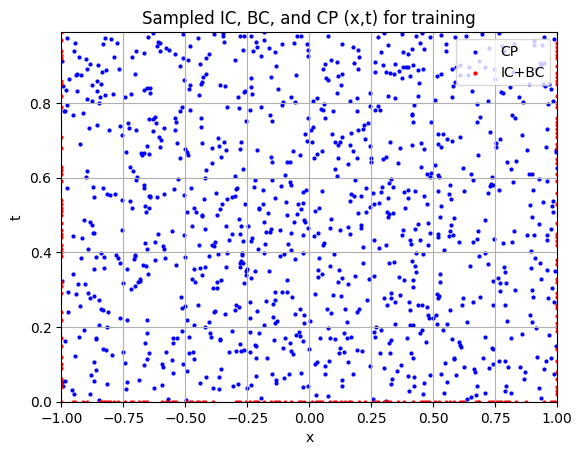

In [16]:
# visualize collocation points for 2D input space (x, t)
plt.figure()
plt.scatter(X_train_CP.detach().numpy(), T_train_CP.detach().numpy(),
            s=4., c='blue', marker='o', label='CP')
plt.scatter(X_train_Nu.detach().numpy(), T_train_Nu.detach().numpy(),
            s=4., c='red', marker='o', label='IC+BC')
plt.title('Sampled IC, BC, and CP (x,t) for training')
plt.xlim(x_lb, x_ub)
plt.ylim(t_lb, t_ub)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('t')
plt.legend(loc='upper right')
plt.show()
plt.show(block=True)

### Create Neuromancer datasets

In [17]:
from neuromancer.dataset import DictDataset

# turn on gradients for PINN
X_train_Nf.requires_grad=True
T_train_Nf.requires_grad=True

# Training dataset
train_data = DictDataset({'x': X_train_Nf, 't':T_train_Nf}, name='train')
# test dataset
test_data = DictDataset({'x': X_test, 't':T_test, 'y':Y_test}, name='test')

# torch dataloaders
batch_size = X_train_Nf.shape[0]  # full batch training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         collate_fn=test_data.collate_fn,
                                         shuffle=False)

## PINN Architecture in Neuromancer

### Neural Network Architecture

We will use a neural network to approximate the PDE solution:
$$\hat{y} = NN_{\theta}(x,t)$$  

In [18]:
from neuromancer.modules import blocks
from neuromancer.system import Node

# neural net to solve the PDE problem bounded in the PDE domain
net = blocks.MLP(insize=2, outsize=1, hsizes=[32, 32], nonlin=nn.Tanh)

# symbolic wrapper of the neural net
pde_net = Node(net, ['x', 't'], ['y_hat'], name='net')

In [19]:
print("symbolic inputs  of the pde_net:", pde_net.input_keys)
print("symbolic outputs of the pde_net:", pde_net.output_keys)

symbolic inputs  of the pde_net: ['x', 't']
symbolic outputs of the pde_net: ['y_hat']


In [20]:
# evaluate forward pass on the train data
net_out = pde_net(train_data.datadict)
net_out['y_hat'].shape

torch.Size([1200, 1])

###  Define Physics-informed terms

Our neural network approximation  must satisfy the PDE equations  $NN_{\theta}(x,t) \approx y(x,t)$.
Thus we define the physics-informed layers as $f_{\texttt{PINN}}$:

$$f_{\texttt{PINN}}(t,x)=
\frac{\partial NN_{\theta}(x,t)}{\partial t}+ NN_{\theta}(x,t) \frac{\partial NN_{\theta}(x,t)}{\partial x} -\nu\frac{\partial^2 NN_{\theta}(x,t)}{\partial x^2}
 $$

We can obtain the derivatives of the neural net $\frac{\partial NN_{\theta}}{\partial t},\frac{\partial^2 NN_{\theta}}{\partial x^2}$ using [Automatic Diferentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).

To simplify the implementation of $f_{\texttt{PINN}}$ we exploit the symbolic variable of the Neuromancer library.

In [21]:
from neuromancer.constraint import variable

# symbolic Neuromancer variables
y_hat = variable('y_hat')  # PDE solution generated as the output of a neural net (pde_net)
t = variable('t')  # temporal domain
x = variable('x')  # spatial domain

In [22]:
# get the symbolic derivatives
dy_dt = y_hat.grad(t)
dy_dx = y_hat.grad(x)
d2y_d2x = dy_dx.grad(x)
# get the PINN form
f_pinn = dy_dt + y_hat*dy_dx - nu*d2y_d2x

In [23]:
# check the shapes of the forward pass of the symbolic PINN terms
print(dy_dt({**net_out, **train_data.datadict}).shape)
print(dy_dx({**net_out, **train_data.datadict}).shape)
print(d2y_d2x({**net_out, **train_data.datadict}).shape)
print(f_pinn({**net_out, **train_data.datadict}).shape)

torch.Size([1200, 1])
torch.Size([1200, 1])
torch.Size([1200, 1])
torch.Size([1200, 1])


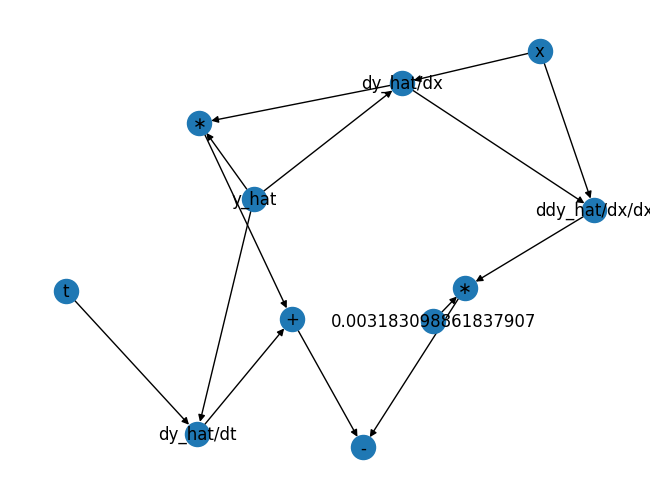

In [24]:
# computational graph of the PINN neural network
f_pinn.show()

### PINNs' Loss function terms

**PDE Collocation Points Loss:**  
We evaluate our PINN $f_{\texttt{PINN}}$ over given number ($N_f$) of collocation points (CP) and minimize the PDE residuals in the following loss function:

$$\ell_{f}=\frac{1}{N_f}\sum^{N_f}_{i=1}|f_{\texttt{PINN}}(t_f^i,x_f^i)|^2$$


If $f_{\texttt{PINN}}\rightarrow 0$ then our PINN will be respecting the physical law.

**PDE Initial and Boundary Conditions Loss:**

We select $N_u$ points from our BC and IC and used them in the following supervised learning loss function:

$$\ell_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|y(t_{u}^i,x_u^i)-NN_{\theta}(t_{u}^i,x_u^i)|^2$$

**Bound the PINN output in the PDE solution domain:**  
We expect the outputs of the neural net to be bounded in the PDE solution domain $NN_{\theta}(x,t) \in [-1.0, 1.0]$, thus we impose the following inequality constraints via additional penalties:

$$\ell_{y}=\frac{1}{N_f}\sum^{N_f}_{i=1} \Big(|\texttt{RELU}(NN_{\theta}(t_{f}^i,x_f^i) - y_{max})|^2 + |\texttt{RELU}(-NN_{\theta}(t_{f}^i,x_f^i) + y_{min})|^2 \Big)$$


#### Total Loss:
The total loss is just a sum of PDE residuals over CP and supervised learning residuals over IC and BC.
$$\ell_{\text{PINN}}=\ell_{f}+\ell_{u} +\ell_{y}$$

In [25]:
# scaling factor for better convergence
scaling = 100.

# PDE CP loss
ell_f = scaling*(f_pinn == 0.)^2

# PDE IC and BC loss
ell_u = scaling*(y_hat[-Nu:] == Y_train_Nu)^2  # remember we stacked CP with IC and BC

# output constraints to bound the PINN solution in the PDE output domain [-1.0, 1.0]
con_1 = scaling*(y_hat <= 1.0)^2
con_2 = scaling*(y_hat >= -1.0)^2

##  Train the PINN to solve the PDE

We use stochastic gradient descent to optimize the parameters $\theta$ of the neural network $NN_{\theta}(t,x)$ approximating the solution to the PDE equation $y(t,x)$ using the PINN loss $\ell_{\text{PINN}}$ evaluated over sampled CP, IP, and BC.

### Define the optimization problem in Neuromancer

In [26]:
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem

# create Neuromancer optimization loss
pinn_loss = PenaltyLoss(objectives=[ell_f, ell_u], constraints=[con_1, con_2])

# construct the PINN optimization problem
problem = Problem(nodes=[pde_net],      # list of nodes (neural nets) to be optimized
                  loss=pinn_loss,       # physics-informed loss function
                  grad_inference=True   # argument for allowing computation of gradients at the inference time)
                 )

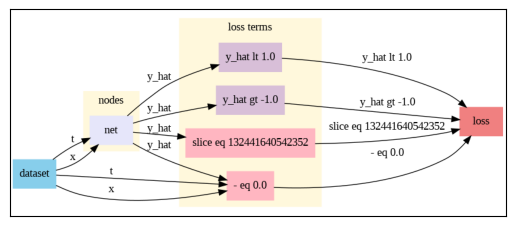

In [27]:
problem.show()

### Construct Trainer and solve the problem  

In [28]:
from neuromancer.trainer import Trainer

optimizer = torch.optim.AdamW(problem.parameters(), lr=0.003)
epochs = 8000

#  Neuromancer trainer
trainer = Trainer(
    problem.to(device),
    train_loader,
    optimizer=optimizer,
    epochs=epochs,
    epoch_verbose=200,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs,
    device=device
)

In [29]:
# Train PINN
best_model = trainer.train()

# load best trained model
problem.load_state_dict(best_model)

epoch: 0  train_loss: 30.703752517700195
epoch: 200  train_loss: 9.102648735046387
epoch: 400  train_loss: 6.4591474533081055
epoch: 600  train_loss: 5.735271453857422
epoch: 800  train_loss: 5.349170207977295
epoch: 1000  train_loss: 5.133112907409668
epoch: 1200  train_loss: 4.9406280517578125
epoch: 1400  train_loss: 4.203588008880615
epoch: 1600  train_loss: 4.001667022705078
epoch: 1800  train_loss: 3.8130249977111816
epoch: 2000  train_loss: 3.6531319618225098
epoch: 2200  train_loss: 3.4784095287323
epoch: 2400  train_loss: 3.2427616119384766
epoch: 2600  train_loss: 3.0018696784973145
epoch: 2800  train_loss: 2.7552003860473633
epoch: 3000  train_loss: 2.5745761394500732
epoch: 3200  train_loss: 2.404827117919922
epoch: 3400  train_loss: 2.3547353744506836
epoch: 3600  train_loss: 2.1632492542266846
epoch: 3800  train_loss: 2.1341185569763184
epoch: 4000  train_loss: 1.932570219039917
epoch: 4200  train_loss: 1.8543543815612793
epoch: 4400  train_loss: 1.8563567399978638
epoch:

<All keys matched successfully>

## Results

In [30]:
# evaluate trained PINN on test data
PINN = problem.nodes[0].cpu()
y1= PINN(test_data.datadict)['y_hat']

# arrange data for plotting
y_pinn = y1.reshape(shape=[256,100]).detach().cpu()

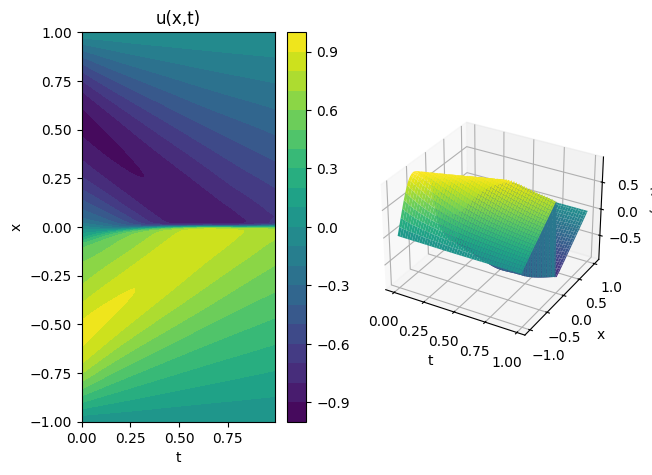

In [31]:
# plot PINN solution
plot3D(X, T, y_pinn)

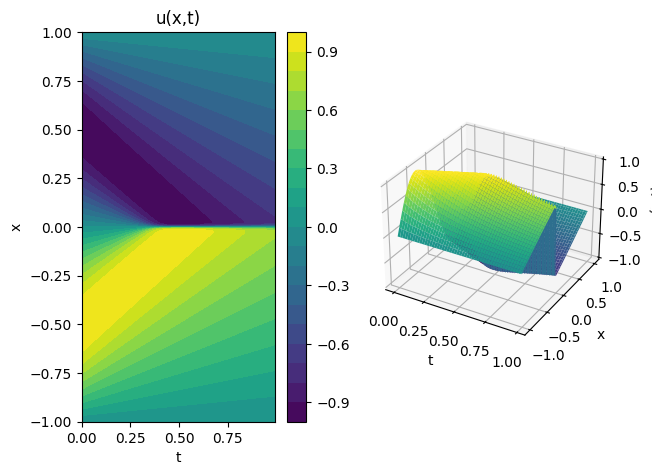

In [32]:
# plot exact PDE solution
plot3D(X, T, y_real)

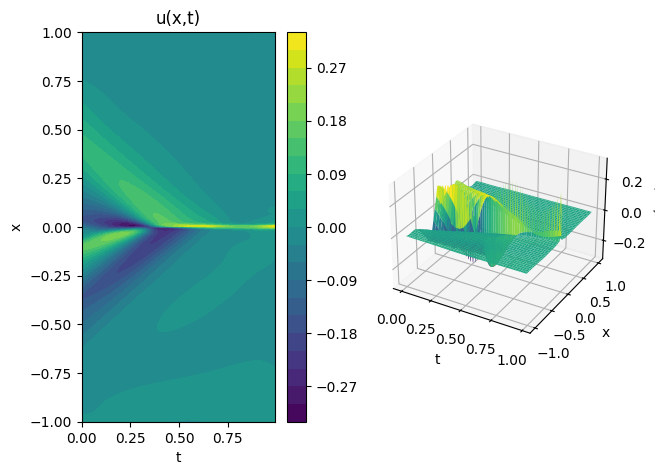

In [33]:
# plot residuals PINN - exact PDE
plot3D(X, T, y_pinn-y_real)